In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

In [4]:
from data_loading import *
from data_preprocessing import *
from model import *

from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
import keras_tuner as kt
from tensorflow.keras.callbacks import ModelCheckpoint


In [5]:
import time
import os

In [6]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
TF_ENABLE_ONEDNN_OPTS=0

In [8]:
# Define the model
def build_model(hp):
    model_lstm = Sequential()
    model_lstm.add(Embedding(input_dim=num_words, output_dim=100, trainable=True, input_length=10, weights=[embedding_wights]))
    model_lstm.add(Bidirectional(LSTM(hp.Int('units_lstm_1', min_value=32, max_value=512, step=32), 
                                      return_sequences=True, 
                                      recurrent_dropout=0.2, 
                                      dropout=0.2, 
                                      kernel_initializer='he_normal', 
                                      bias_initializer='he_normal', 
                                      kernel_regularizer=l2(1e-7)), 'concat'))
    model_lstm.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.05)))
    model_lstm.add(LSTM(hp.Int('units_lstm_2', min_value=32, max_value=512, step=32), 
                        return_sequences=True, 
                        recurrent_dropout=0.2, 
                        dropout=0.2, 
                        kernel_initializer='he_normal', 
                        bias_initializer='he_normal', 
                        kernel_regularizer=l2(1e-7)))
    model_lstm.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.05)))
    model_lstm.add(LSTM(hp.Int('units_lstm_3', min_value=32, max_value=512, step=32), 
                        return_sequences=False, 
                        recurrent_dropout=0.2, 
                        dropout=0.2, 
                        kernel_initializer='he_normal', 
                        bias_initializer='he_normal', 
                        kernel_regularizer=l2(1e-7)))
    model_lstm.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.05)))
    model_lstm.add(Dense(hp.Int('units_dense', min_value=32, max_value=512, step=32), 
                         activation='sigmoid', 
                         kernel_initializer='he_normal', 
                         bias_initializer='he_normal', 
                         kernel_regularizer=l2(1e-7)))
    model_lstm.add(Dropout(hp.Float('dropout_4', min_value=0.0, max_value=0.5, step=0.05)))
    model_lstm.add(Dense(10, activation='softmax'))
    model_lstm.compile(loss ='categorical_crossentropy', optimizer =Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), metrics = ["accuracy"])
    return model_lstm
# Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     
                     directory='lstm_model',
                     project_name='lstm_model')


INFO:tensorflow:Reloading Tuner from lstm_model/lstm_model/tuner0.json


In [11]:




# Define the callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=12, verbose=1, factor=0.1, min_delta=0.001, min_lr=0.00001)
checkpoint_path = "training_checkpoints/lstm-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, early_stopping, cp_callback]

# Perform hyperparameter tuning
tuner.search(train_data, train_classes, epochs=50, validation_data=(val_data, val_classes), callbacks=callbacks_list)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history_LSTM = best_model.fit(x=train_data, y=train_classes, epochs=50,
                        batch_size=128, shuffle=True,
                        validation_data=(val_data, val_classes),
                        callbacks=callbacks_list,
                        )




Trial 31 Complete [00h 56m 52s]
val_accuracy: 0.6318444609642029

Best val_accuracy So Far: 0.6625333428382874
Total elapsed time: 1d 02h 28m 01s

Search: Running Trial #32

Value             |Best Value So Far |Hyperparameter
480               |448               |units_lstm_1
0.15              |0.45              |dropout_1
384               |416               |units_lstm_2
0                 |0.25              |dropout_2
192               |32                |units_lstm_3
0.1               |0.25              |dropout_3
64                |384               |units_dense
0.05              |0.2               |dropout_4
0.01              |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
6563/6563 [==============================] - ETA: 0s - loss: 2.3094 - accuracy: 0.0992
Epoch 1: val_accu

KeyboardInterrupt: 

In [37]:
# Save the best hyperparameters
best_hps = {'units_lstm_1': 448,
 'dropout_1': 0.45,
 'units_lstm_2': 416,
 'dropout_2': 0.25,
 'units_lstm_3': 32,
 'dropout_3': 0.25,
 'units_dense': 384,
 'dropout_4': 0.2,
 'learning_rate': 1.0e-2}

# Open a file in write mode
with open('best_hyperparameters_lstm.txt', 'w') as f:
    # Write the hyperparameters to the file
    f.write('The optimal number of units in the first LSTM layer is: {}\n'.format(best_hps.get('units_lstm_1')))
    f.write('The optimal dropout rate after the first LSTM layer is: {}\n'.format(best_hps.get('dropout_1')))
    f.write('The optimal number of units in the second LSTM layer is: {}\n'.format(best_hps.get('units_lstm_2')))
    f.write('The optimal dropout rate after the second LSTM layer is: {}\n'.format(best_hps.get('dropout_2')))
    f.write('The optimal number of units in the third LSTM layer is: {}\n'.format(best_hps.get('units_lstm_3')))
    f.write('The optimal dropout rate after the third LSTM layer is: {}\n'.format(best_hps.get('dropout_3')))
    f.write('The optimal number of units in the dense layer is: {}\n'.format(best_hps.get('units_dense')))
    f.write('The optimal dropout rate after the dense layer is: {}\n'.format(best_hps.get('dropout_4')))
    f.write('The optimal learning rate for the optimizer is: {}\n'.format(best_hps.get('learning_rate')))


In [9]:

import ast

best_hps = {}

with open('best_hyperparameters_lstm.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        # Split the line at the colon
        key, value = line.split(':')
        # Remove unnecessary characters and convert to the appropriate type
        key = key.strip().lower().replace('the optimal ', '').replace(' for the optimizer', '').replace(' ', '_')
        value = float(value.strip())
        best_hps[key] = value

In [11]:
best_hps

{'number_of_units_in_the_first_lstm_layer_is': 448.0,
 'dropout_rate_after_the_first_lstm_layer_is': 0.45,
 'number_of_units_in_the_second_lstm_layer_is': 416.0,
 'dropout_rate_after_the_second_lstm_layer_is': 0.25,
 'number_of_units_in_the_third_lstm_layer_is': 32.0,
 'dropout_rate_after_the_third_lstm_layer_is': 0.25,
 'number_of_units_in_the_dense_layer_is': 384.0,
 'dropout_rate_after_the_dense_layer_is': 0.2,
 'learning_rate_is': 0.01}

In [10]:
from kerastuner import HyperParameters

# Create a new HyperParameters object
hp = HyperParameters()

# Set the values
# Set the hyperparameters to their optimal values
hp.Fixed('number_of_units_in_the_first_lstm_layer_is', value=best_hps['number_of_units_in_the_first_lstm_layer_is'])
hp.Fixed('dropout_rate_after_the_first_lstm_layer_is', value=best_hps['dropout_rate_after_the_first_lstm_layer_is'])
hp.Fixed('number_of_units_in_the_second_lstm_layer_is', value=best_hps['number_of_units_in_the_second_lstm_layer_is'])
hp.Fixed('dropout_rate_after_the_second_lstm_layer_is', value=best_hps['dropout_rate_after_the_second_lstm_layer_is'])
hp.Fixed('number_of_units_in_the_third_lstm_layer_is', value=best_hps['number_of_units_in_the_third_lstm_layer_is'])
hp.Fixed('dropout_rate_after_the_third_lstm_layer_is', value=best_hps['dropout_rate_after_the_third_lstm_layer_is'])
hp.Fixed('number_of_units_in_the_dense_layer_is', value=best_hps['number_of_units_in_the_dense_layer_is'])
hp.Fixed('dropout_rate_after_the_dense_layer_is', value=best_hps['dropout_rate_after_the_dense_layer_is'])
hp.Fixed('learning_rate_is', value=best_hps['learning_rate_is'])

# Build the model with the optimal hyperparameters
best_model_lstm = build_model(hp)

# Now you can use this hp object to build the model
best_model_lstm = tuner.hypermodel.build(hp)



In [11]:
# Load the best hyperparameters
# with open('best_hyperparameters_lstm.txt', 'r') as f:
#     best_hps = eval(f.read())


# Define the callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.2, min_delta=0.001, min_lr=0.00001)
checkpoint_path = "training_checkpoints/lstm-cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [reduce_lr, early_stopping, cp_callback]

# Train the model for 10 epochs
with tf.device('/GPU:0'):
    history_LSTM = best_model_lstm.fit(x=train_data, y=train_classes, epochs=50,
                        batch_size=128, shuffle=True,
                        validation_data=(val_data, val_classes),
                        callbacks=callbacks_list,
                        )

# Initialize lists to store the loss values
train_loss = []
val_loss = []
train_acc = []
val_acc = []

# Append the loss values to the lists
train_loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']
train_acc = history_LSTM.history['accuracy']
val_acc = history_LSTM.history['val_accuracy']

# Save loss to txt files
if not os.path.exists('Epoch_history'):
    os.makedirs('Epoch_history')
np.savetxt('Epoch_history/train_loss_lstm.txt', train_loss, delimiter=',')
np.savetxt('Epoch_history/val_loss_lstm.txt', val_loss, delimiter=',')
np.savetxt('Epoch_history/train_acc_lstm.txt', train_acc, delimiter=',')
np.savetxt('Epoch_history/val_acc_lstm.txt', val_acc, delimiter=',')



Epoch 1/50


2023-06-04 19:16:29.364615: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7522/7522 [==============================] - ETA: 0s - loss: 1.1510 - accuracy: 0.6390
Epoch 1: val_accuracy improved from -inf to 0.66228, saving model to training_checkpoints/lstm-cp-0001.ckpt
INFO:tensorflow:Assets written to: training_checkpoints/lstm-cp-0001.ckpt/assets
7522/7522 [==============================] - 2060s 273ms/step - loss: 1.1510 - accuracy: 0.6390 - val_loss: 1.0772 - val_accuracy: 0.6623 - lr: 0.0100
Epoch 2/50
7522/7522 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.6831
Epoch 2: val_accuracy did not improve from 0.66228
7522/7522 [==============================] - 2013s 268ms/step - loss: 1.0168 - accuracy: 0.6831 - val_loss: 1.0882 - val_accuracy: 0.6600 - lr: 0.0100
Epoch 3/50
7522/7522 [==============================] - ETA: 0s - loss: 0.9718 - accuracy: 0.7000
Epoch 3: val_accuracy did not improve from 0.66228
7522/7522 [==============================] - 1827s 243ms/step - loss: 0.9718 - accuracy: 0.7000 - val_loss: 1.1020 - val_acc

In [20]:
# Build a new model with the same architecture
model = build_model(hp)

# Load the weights from the best model
model.load_weights('training_checkpoints/lstm-cp-0002.ckpt')


2023-06-05 03:35:11.156091: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open training_checkpoints/lstm-cp-0002.ckpt: FAILED_PRECONDITION: training_checkpoints/lstm-cp-0002.ckpt; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


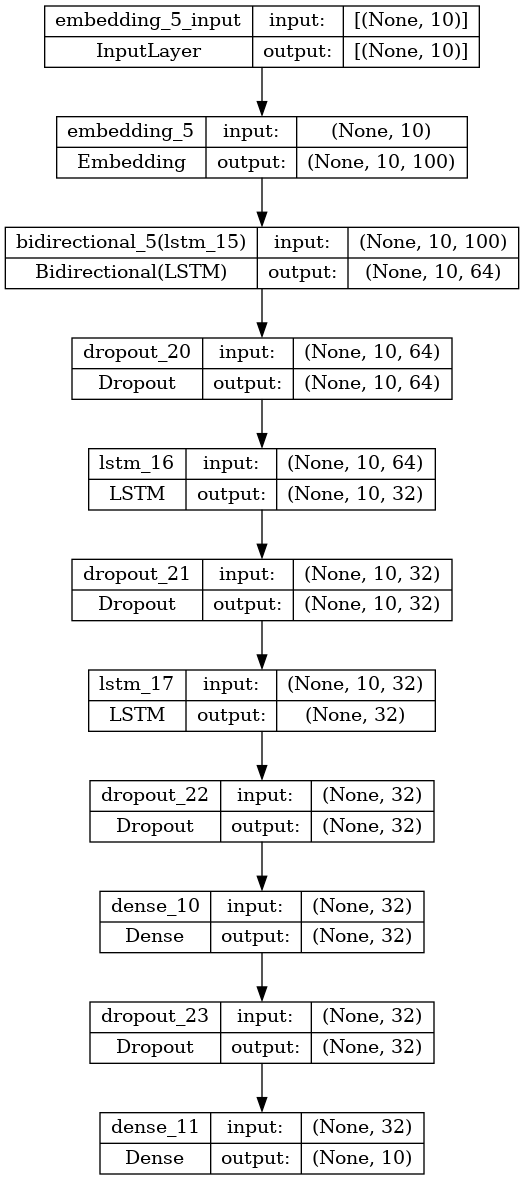

In [18]:
from keras.utils.vis_utils import plot_model
# plot the model diavgram
plot_model(best_model_lstm, to_file='LSTM_2_model_diagram.png', show_shapes=True, show_layer_names=True)

In [19]:
best_hps

{'number_of_units_in_the_first_lstm_layer_is': 448.0,
 'dropout_rate_after_the_first_lstm_layer_is': 0.45,
 'number_of_units_in_the_second_lstm_layer_is': 416.0,
 'dropout_rate_after_the_second_lstm_layer_is': 0.25,
 'number_of_units_in_the_third_lstm_layer_is': 32.0,
 'dropout_rate_after_the_third_lstm_layer_is': 0.25,
 'number_of_units_in_the_dense_layer_is': 384.0,
 'dropout_rate_after_the_dense_layer_is': 0.2,
 'learning_rate_is': 0.01}

In [17]:
best_model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 100)           28197700  
                                                                 
 bidirectional_5 (Bidirectio  (None, 10, 64)           34048     
 nal)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_16 (LSTM)              (None, 10, 32)            12416     
                                                                 
 dropout_21 (Dropout)        (None, 10, 32)            0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                8320      
                                                      

In [8]:
# from tensorflow.keras.models import load_model

# # If previous model exists, load it
# if os.path.exists('save/LSTM_model.h5'):
#     model_lstm = load_model('save/LSTM_model.h5')


In [14]:
# %%time

# # The result may differ slightly with the final report

# # Save model after every 10 epochs
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=1, verbose=1, factor=0.1, min_delta=0.001, min_lr=0.00001)
    
# with tf.device('/GPU:0'):
   
#     # Train the model for 10 epochs
    
#     history_LSTM = model.fit(x=train_data, y=train_classes,
#                         batch_size=1024, shuffle=True,
#                         validation_data=(val_data, val_classes),
#                         callbacks=[reduce_lr, early_stopping],
#                         epochs = 40)

# # Save model
# model.save(f'save/LSTM_model_epoch_swish.h5')
    
# # Append the loss values to the lists
# train_loss = history_LSTM.history['loss']
# val_loss = history_LSTM.history['val_loss']
# train_acc = history_LSTM.history['accuracy']
# val_acc = history_LSTM.history['val_accuracy']

# # Save loss to txt files
# if not os.path.exists('Epoch_history'):
#     os.makedirs('Epoch_history')
# np.savetxt('Epoch_history/train_loss_lstm_swish.txt', train_loss, delimiter=',')
# np.savetxt('Epoch_history/val_loss_lstm_swish.txt', val_loss, delimiter=',')
# np.savetxt('Epoch_history/train_acc_lstm_swish.txt', train_acc, delimiter=',')
# np.savetxt('Epoch_history/val_acc_lstm_swish.txt', val_acc, delimiter=',')

Epoch 1/40
941/941 [==============================] - 237s 252ms/step - loss: 1.0393 - accuracy: 0.6737 - val_loss: 1.0103 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/40
941/941 [==============================] - 268s 285ms/step - loss: 0.9734 - accuracy: 0.6941 - val_loss: 1.0073 - val_accuracy: 0.6810 - lr: 0.0010
Epoch 3/40
941/941 [==============================] - ETA: 0s - loss: 0.9189 - accuracy: 0.7108
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
941/941 [==============================] - 259s 275ms/step - loss: 0.9189 - accuracy: 0.7108 - val_loss: 1.0057 - val_accuracy: 0.6813 - lr: 0.0010
Epoch 4/40
941/941 [==============================] - 255s 271ms/step - loss: 0.8553 - accuracy: 0.7312 - val_loss: 1.0179 - val_accuracy: 0.6833 - lr: 1.0000e-04
Epoch 5/40
941/941 [==============================] - ETA: 0s - loss: 0.8472 - accuracy: 0.7331
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
941/941 [================

In [ ]:
import matplotlib

import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (8, 6)

train_loss = np.loadtxt('Epoch_history/train_loss_lstm.txt', delimiter=',')
val_loss = np.loadtxt('Epoch_history/val_loss_lstm.txt', delimiter=',')

plt.plot(train_loss)
plt.plot(val_loss,)
epochs = range(0, len(val_loss),2)

plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.grid()
plt.xticks(epochs)

plt.show()

In [ ]:
# plt.plot(history_LSTM.history['accuracy'])
# plt.plot(history_LSTM.history['val_accuracy'])
matplotlib.rcParams['figure.figsize'] = (8, 6)

train_acc = np.loadtxt('Epoch_history/train_acc_lstm.txt', delimiter=',')
val_acc = np.loadtxt('Epoch_history/val_acc_lstm.txt', delimiter=',')
plt.plot(train_acc)
plt.plot(val_acc,)
epochs = range(0, len(train_acc),2)

plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.grid()
plt.xticks(epochs)

plt.show()

In [18]:
# from tensorflow.keras.models import load_model

# # If previous model exists, load it
# if os.path.exists('save/LSTM_model_epoch_swish.h5'):
#     model_lstm = load_model('save/LSTM_model_epoch_swish.h5')

## Test

In [34]:
checkpoint_dir

'training_checkpoints'

In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters

# Create a HyperParameters object
hp = HyperParameters()

# Set the values
hp.Fixed('units_lstm_1', value=int(best_hps['number_of_units_in_the_first_lstm_layer_is']))
hp.Fixed('dropout_1', value=best_hps['dropout_rate_after_the_first_lstm_layer_is'])
hp.Fixed('units_lstm_2', value=int(best_hps['number_of_units_in_the_second_lstm_layer_is']))
hp.Fixed('dropout_2', value=best_hps['dropout_rate_after_the_second_lstm_layer_is'])
hp.Fixed('units_lstm_3', value=int(best_hps['number_of_units_in_the_third_lstm_layer_is']))
hp.Fixed('dropout_3', value=best_hps['dropout_rate_after_the_third_lstm_layer_is'])
hp.Fixed('units_dense', value=int(best_hps['number_of_units_in_the_dense_layer_is']))
hp.Fixed('dropout_4', value=best_hps['dropout_rate_after_the_dense_layer_is'])
hp.Fixed('learning_rate', value=best_hps['learning_rate_is'])

# Create a new instance of the same model architecture
model = build_model(hp)

# Load the weights from the checkpoint
model.load_weights('training_checkpoints/lstm-cp-0002.ckpt')

# Now the model instance has the same weights as the one saved in the checkpoint



In [18]:
# with open('data_sequences_test.pkl','rb') as file:
#   test_data = pickle.load(file)

# with open('data_label_test.pkl','rb') as file:
#   test_labels = pickle.load(file)
test_data = test_data
test_labels = test_classes

In [43]:
from sklearn.metrics import classification_report
target_names = class_names
y_true = np.argmax(test_labels, axis=1) 
y_pred = np.argmax(predictions, axis=1) 
print(classification_report(y_true=y_true,y_pred= y_pred, target_names=target_names))

                        precision    recall  f1-score   support

     Society & Culture       0.59      0.46      0.52     20687
 Science & Mathematics       0.79      0.84      0.81     20123
                Health       0.54      0.48      0.51     20645
 Education & Reference       0.71      0.64      0.67     20636
  Computers & Internet       0.60      0.73      0.66     20086
                Sports       0.71      0.75      0.73     20550
    Business & Finance       0.68      0.77      0.72     20800
 Entertainment & Music       0.66      0.72      0.69     20998
Family & Relationships       0.60      0.53      0.56     20805
 Politics & Government       0.85      0.85      0.85     20983

              accuracy                           0.68    206313
             macro avg       0.67      0.68      0.67    206313
          weighted avg       0.67      0.68      0.67    206313



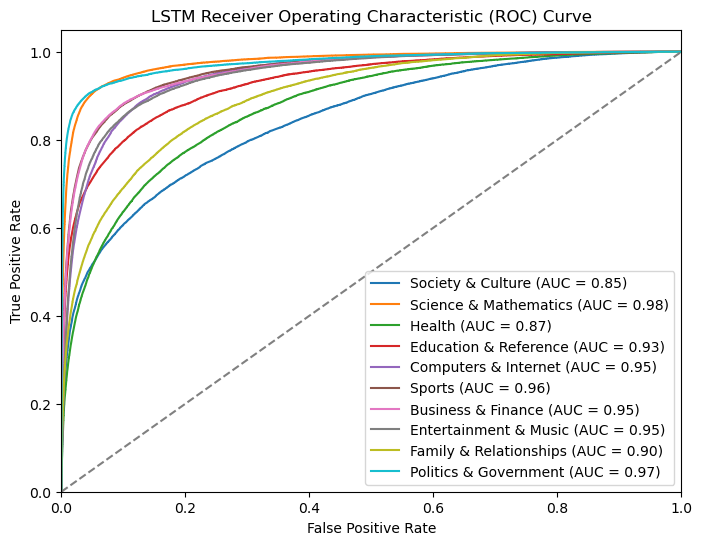

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib as mpl
matplotlib.rcParams['figure.figsize'] = (8, 6)

mpl.rcParams['font.size'] = 10




# Make predictions on the test set
predictions =predictions

# Convert the labels to categorical format
test_labels_cat = test_labels

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_cat[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [45]:
from sklearn.metrics import roc_auc_score
y_pred = predictions
score = roc_auc_score(test_labels, y_pred)
print("\n ROC-AUC score: %.6f \n" % (score))


 ROC-AUC score: 0.929936 



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
matplotlib.rcParams['figure.figsize'] = (8, 6)

# Define the class labels
class_names = ['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 
               'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government']


# Make predictions on the test set
predictions = model.predict(test_data)



6448/6448 [==============================] - 94s 14ms/step


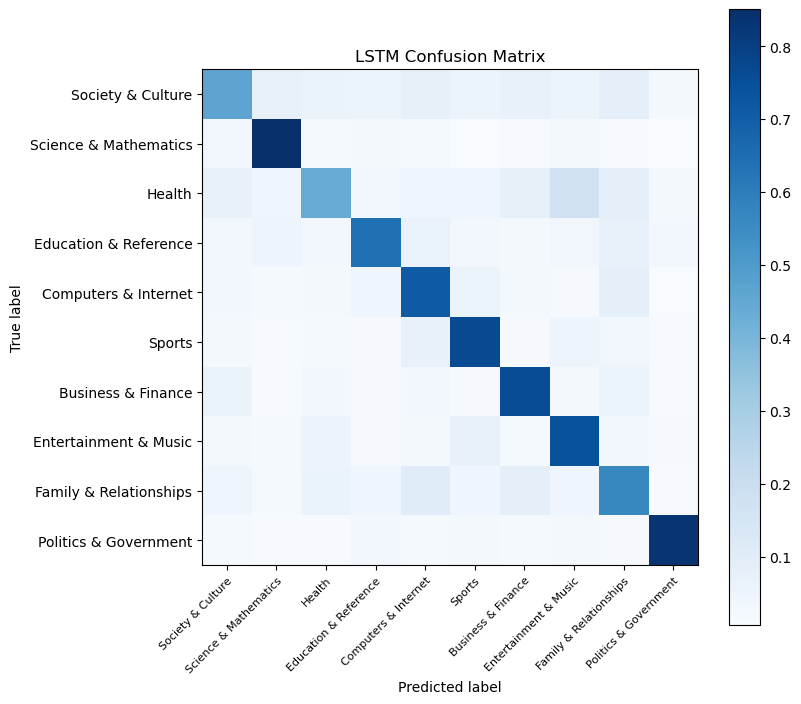

Accuracy: 0.676467309379438


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1), normalize='true')

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set labels and title
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('LSTM Confusion Matrix')

# Add category labels
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=8, va='top', rotation_mode='anchor')
plt.yticks(tick_marks, class_names)

# Ensure x-axis labels start from the beginning
ax.set_xlim(left=-0.5)

# Show the plot
plt.show()

# Calculate and print the accuracy
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(test_labels, axis=1)) / len(np.argmax(test_labels, axis=1))
print('Accuracy:', accuracy)
